# A bit more of analysis

Let's now go deeper into the analysis by: 
- converting MSB into other physical units
- estimating the uncertainties on the measured brightnesses

## Conversion of MSB to other physical units

What is MSB? = Mean Solar Brightness, i.e. the average brightness of the solar disc (considering that the centre is brighter than the limb due to limb darkening). In practice, when one observe an eclipse, one can take an image of the Sun before/after the eclipse with exactly the same instrument (including filter), measure the average brightness of the disc in raw units from the camera (e.g. DN), then divide the raw data of the coronal pixels taken during the eclipse by this average brightness. The result is then expressed in MSB, leaving absolute calibration for later (i.e. leaving anyone the freedom to calibrate the solar brightness). 

For ASPIICS, observing the solar disc is not possible, so we had to estimate, from the absolute calibration, the corresponding number of photons or other irradiance units that we would get through the instrument if we observed the solar disc. 

These coefficients are provided in the Level-2 or Level-3 FITS header. **They are different for each filter.** 


A possible method is:
1. take the values from the level-2 or 3 file (in MSB)

In [65]:
from astropy.io import fits
import numpy as np

filename="./tutorial_data/aspiics_bt_l3_1320404D0002_20250812T181424.fits"

with fits.open(filename) as hdul:
    data_l3_MSB=hdul[0].data

data_l3_MSB=np.array(data_l3_MSB, dtype=float)
header=hdul[0].header

# Check the min and max of the pixels with finite values
mask_finite=np.isfinite(data_l3_MSB)
print(np.min(data_l3_MSB[mask_finite]), np.max(data_l3_MSB[mask_finite]))


3.3639757646142243e-14 5.49807964489446e-06


2. multiply the image in MSB by the keyword A_PHOT (for wideband, A_PHOT = 23600000000.0 DN/s/MSB). We now have values in DN/s (like they were in Level-1, except that now dark current was removed, flatfield and non-linearity correction was applied, etc...)

In [66]:
# Conversion to DN/s
data_l3_DN=data_l3_MSB*header['A_PHOT']

# Check the min and max of the pixels with finite values
mask_finite=np.isfinite(data_l3_DN)
print(np.min(data_l3_DN[mask_finite]), np.max(data_l3_DN[mask_finite]))

0.0007938982804489569 129754.67961950926


3. multiply them by the keyword corresponding to the target units:
   - CONV_PHO (=1.13E-10 for Wideband) to convert from DN/s to photon/s/cm^2/sr
   - CONV_WAT (=31078.11 for wideband) to convert from DN/s to W/m^2/sr
   - CONV_ERG (=31.08  for wideband) to convert from DN/s to erg/s/cm^2/sr 

In [67]:
# Conversion to photon units
data_l3_photon=data_l3_DN/header['CONV_PHO']

# Check the min and max of the pixels with finite values
mask_finite=np.isfinite(data_l3_photon)
print(np.min(data_l3_photon[mask_finite]), np.max(data_l3_photon[mask_finite]))

7025648.499548292 1148271501057604.0


# Estimating photon shot noise and Signal-to-Noise Ratio (SNR) 

Valid for any Level-2 files. Note that this is "quick and dirty" and neglect some calibration steps that have negligible contribution. 

Read the Level-2 file (downloaded in the last section of the "Downloading" notebook):

In [68]:
from astropy.io import fits
import numpy as np

filename="./tutorial_data/aspiics_wb_l2_1320404D000212_20250812T181424.fits"

with fits.open(filename) as hdul:
    data_l2_MSB=hdul[0].data

data_l2_MSB=np.array(data_l2_MSB, dtype=float)
header_l2=hdul[0].header


To get the correct photon statistics, we use the parent Level-1 file (that you have also downloaded in the last part of the "Downloading" notebook): 

In [69]:
filename_parent='./tutorial_data/'+header_l2['PARENT']
print('Reading parent file ', filename_parent)

with fits.open(filename_parent) as hdul:
    data_l1_DN=hdul[0].data

data_l1_DN=np.array(data_l1_DN, dtype=float)


Reading parent file  ./tutorial_data/aspiics_wb_l1_1320404D000212_20250812T181424.fits


The bias of the detector does not contribute to the photon noise, so you need to download the calibration files locally if this is not already the case: https://gitlab-as.oma.be/P3SC/p3sc_calibration_data_repository/-/releases/v1.0

For this task, you mainly need the files 'bias_A.fits' and 'bias_B.fits' to calculate the bias contribution in the iamge. They contain the matrices of the coefficient of the detector bias: A is a constant, B depends on the detector temperature.  

In [70]:
fname_biasA='./cal/bias_A.fits'
fname_biasB='./cal/bias_B.fits'

with fits.open(fname_biasA) as hdul:
    biasA=np.array(hdul[0].data, dtype=float)
with fits.open(fname_biasB) as hdul:
    biasB=np.array(hdul[0].data, dtype=float)

bias=biasA+biasB*header_l2['APS_temp']


Let's have a look at how the detector bias looks like:  

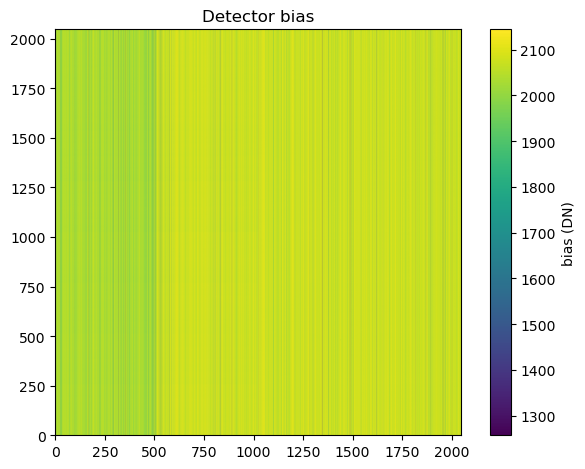

In [71]:
import matplotlib.pyplot as plt

plt.imshow(bias, origin="lower") 
plt.colorbar(label="bias (DN)")
plt.title('Detector bias')
plt.tight_layout()
plt.show()

Now let's cheat to go faster and use rough values for some other calibration parameters, instead of searching for them in the calibration files: 

In [72]:
gain=0.119            # or 0.1, take the latest calibration detector gain
readout_noise=7       # (take the latest calibration detector readout noise)


So, our real photon count (not DNs) and the associated photon noise are: 

In [73]:
data_l1_photon=(data_l1_DN-bias)/gain
print(np.nanmin(data_l1_photon), np.nanmax(data_l1_photon))
photon_noise=np.sqrt(data_l1_photon)

-491.92899816176475 125986.06244255515


C:\Users\laurentd\AppData\Local\Temp\ipykernel_18020\253620703.py:3: RuntimeWarning: invalid value encountered in sqrt
  photon_noise=np.sqrt(data_l1_photon)


Now what we need is to determine the equivalent noise/uncertainty in DNs, also adding quadratically the detector readout noise: 

In [74]:
DN_noise=photon_noise*gain
Total_DN_noise=np.sqrt(DN_noise**2 + readout_noise**2)

With the noise, we can actually calculate the Signal-to-Noise Ratio (SNR): 

In [75]:
SNR=(data_l1_DN-bias)/Total_DN_noise

Figure of the SNR: 

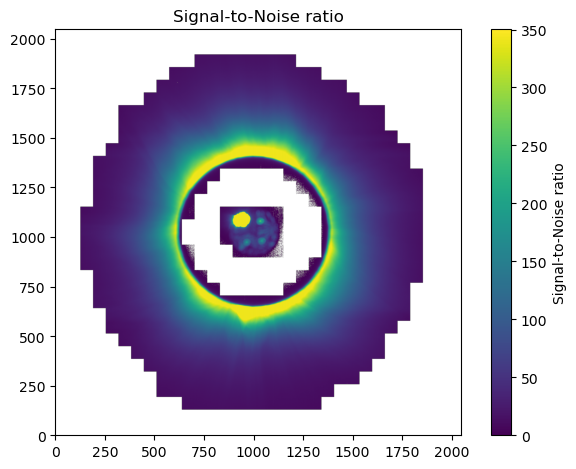

In [76]:
plt.imshow(SNR, origin="lower") 
plt.colorbar(label="Signal-to-Noise ratio")
plt.title('Signal-to-Noise ratio')
plt.tight_layout()
plt.show()

Let's convert the uncertainty in DN into an uncertainty in MSB: 

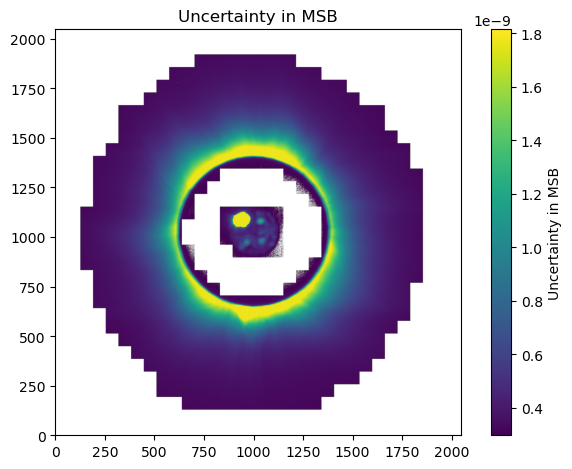

In [77]:
Uncertainty_MSB=Total_DN_noise/header_l2['A_PHOT']/header_l2['EXPTIME']

plt.imshow(Uncertainty_MSB, origin="lower") 
plt.colorbar(label="Uncertainty in MSB")
plt.title('Uncertainty in MSB')
plt.tight_layout()
plt.show()


Next steps: propagating these uncertainties when re-centering, rotating and merging the exposure for Level-3. Beware that starting from Level-3 and converting to DN/s (as above) would imply neglecting the photon noise of the dark current and of the F corona, which are removed already in Level-3. 